#AIDI 1100_01 
#FINAL PROJECT
#GROUP4

In [1]:
#To import all the required libraries

import requests
from bs4 import BeautifulSoup
import datetime
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
# Global Variables
arr_Date = []
arr_newsTitle = []
arr_newsPara = []
arr_newsUrl = []
selected_stock= []

Total_Days = 7 #Number of days to fetch
StockSymbol_Required = 2 #Number of stock symbols to compare
currentDate = datetime.datetime.now()
tempDate = currentDate
stockPeriod = 60
strEndDate = datetime.date.strftime(currentDate, "%Y-%m-%d")
strStartDate = datetime.date.strftime(currentDate - datetime.timedelta(days=stockPeriod), "%Y-%m-%d")
strFiveYearDate = datetime.date.strftime(currentDate.replace(year=currentDate.year - 5), "%Y-%m-%d")
StockIndustry_Search = ''

#Data Extraction Methods

In [3]:
#To fetch the news url
def getNewsUrl():
  News_URL = "https://www.prnewswire.com/news-releases/news-releases-list/?"
  return News_URL

#To prepare url by appending month-day-year to the above url to fetch the details
def prepare_URL(dayToFetch) -> str:
  news_url = getNewsUrl()
  urlByDay = news_url + 'month=' + str(currentDate.month) + '&day=' + str(dayToFetch) + '&year=' + str(currentDate.year) + '&hour=00&page=1&pagesize=100'
  return urlByDay

#***************************************************************************
#function name : parse_News
#function Task : To parse news url using BeautifulSoup and fetch the required 
#content from the parse data
#input value   : forDay - current day to past 7 days
#***************************************************************************
def parse_News(forDay):
  url = prepare_URL(forDay)
  page = requests.get(url)
  soup = BeautifulSoup(page.content, "html.parser")

  # To extract main layout content
  main = soup.find_all('main',class_='headline-listing')

  for elements in main:
    lstContainer = elements.find_all('section',class_='container')
    for mainHead in lstContainer:
      row = mainHead.find_all('div',class_='row')
      for mainCol in row:
        rowList = mainCol.find_all('div',class_='col-md-8 col-sm-8 card-list card-list-hr')
        for newsCard in rowList:
          newsLst = newsCard.find_all('a',class_='newsreleaseconsolidatelink')
          for content in newsLst:
            href = content.get('href')
            small = content.h3.small.text
            content.h3.small.decompose()
            h3 = content.h3.text.replace("\n", "")
            p =  content.p.text
            arr_Date.append(small)
            arr_newsTitle.append(h3)
            arr_newsPara.append(p)
            arr_newsUrl.append(href)

#***************************************************************************
#function name : fetchNewsData
#function Task :while loop iterate for given days here - 7 days
#function Called: parse_News()
#***************************************************************************
def fetchNewsData():
  #Fetch & Parse data of last week
  i = 0
  print('Fetching Data....')
  while i < Total_Days:
    parse_News(currentDate.day - i)
    i = i + 1
  print('Download completed....')

**Fetch Data**

In [4]:
#To initialise the fetching of data from news url and parse the details
fetchNewsData()

Fetching Data....
Download completed....


#Data Storing

In [5]:
# Write data to csv
dictNews = {'Date': arr_Date, 'Title': arr_newsTitle, 'Content': arr_newsPara, 'Url': arr_newsUrl}
df = pd.DataFrame(dictNews)
df.to_csv('newsData.csv')
df.head()

,Date,Title,Content,Url
0,00:00 ET,SHAREHOLDER INVESTIGATION: Halper Sadeh LLP In...,"Halper Sadeh LLP, a global investor rights law...",/news-releases/shareholder-investigation-halpe...
1,00:00 ET,EMAAR NEW YEAR'S EVE CELEBRATIONS INVITE THE W...,"Emaar, the UAE's globally renowned and recogni...",/news-releases/emaar-new-years-eve-celebration...
2,"Dec 13, 2021, 23:55 ET",SHAREHOLDER ALERT: Pomerantz Law Firm Investig...,Pomerantz LLP is investigating claims on behal...,/news-releases/shareholder-alert-pomerantz-law...
3,"Dec 13, 2021, 23:55 ET",SHAREHOLDER ALERT: Pomerantz Law Firm Investig...,Pomerantz LLP is investigating claims on behal...,/news-releases/shareholder-alert-pomerantz-law...
4,"Dec 13, 2021, 23:50 ET",Orelabrutinib Data Presented at the 63rd Annua...,"InnoCare Pharma (HKEX: 09969), a leading biote...",/news-releases/orelabrutinib-data-presented-at...


#Get & Search Stock Industry

In [6]:
#***************************************************************************
#function name : isValidInput
#function Task :To validate the input provide is in the range of 1 to 3
#function input : val - the value entered by the user
#***************************************************************************
def isValidInput(val):
  try:
    int(val)
    return True
  except ValueError:
    print('\nINVALID INPUT: Please enter numeric choice\n')
    return False

#*********************************************************************************
#function name : showCompanyList
#function Task :To show the list of 3 stock industry to ask for input from user 
#function input : no arguement passed
#return Value : returns bool value if entered value is with in the range of 1 to 3
#returns true else returns false
#*********************************************************************************
def showCompanyList():
  print('SELECT INDUSTRY TO GET STOCK SYMBOLS:\n')
  print(" 1.NYSE (New York Stock Exchange) \n 2.TSX (Toronto Stock Exchange) \n 3.NASDAQ (National Association of Securities Dealers Automated Quotation)")
  choice = input("\nEnter numerical choice: ")
  if isValidInput(choice) == True:
    return int(choice)
  else:
    return 0
  
#To get stock company list and to validate the input provided
def chooseStockIndustry():
  getChoice = showCompanyList()
  if (getChoice < 4 and getChoice > 0):
    global StockIndustry_Search
    StockIndustry_Search = getStockIndustry(getChoice)
  else:
    chooseStockIndustry()

#To return stock company name from selected choice

def getStockIndustry(choiceIndex):
  stock_ex = {1:'NYSE', 2:'TSX', 3:'NASDAQ'}
  selectedIndustry = stock_ex[int(choiceIndex)]
  print('Selected industry is:',selectedIndustry)
  return selectedIndustry

**Get User choice for Stock industry**


In [7]:
#chooseStockIndustry function called to display list and ask form input
chooseStockIndustry()

SELECT INDUSTRY TO GET STOCK SYMBOLS:

 1.NYSE (New York Stock Exchange) 
 2.TSX (Toronto Stock Exchange) 
 3.NASDAQ (National Association of Securities Dealers Automated Quotation)

Enter numerical choice: 1
Selected industry is: NYSE


#Get and Search Stock Symbols for selected Stock Industry

In [8]:
#regex : to fetch the stock list from selected industry.
#for e.g: regex -> (NSE:AALP)
# it will parse the list after  'company name:'
#duplicate and null values are removed from the list obtained

regex = StockIndustry_Search + ': ([a-zA-Z]+)'
df_stockSymbols = df['Content'].str.extract(regex, expand=False)
# Dropping the duplicates 
df_stockSymbols = df_stockSymbols.drop_duplicates()
# Dropping the missing values.
df_stockSymbols = df_stockSymbols.dropna()

**Get User choice for Stock Symbols**

In [9]:
#From the list retrieved above is filtered and top 5 item is shown
# index value is set from 1 to 5 for the given list

print('SELECT TWO STOCKS:\n')
stocks = df_stockSymbols.head(5).tolist()
for i, item in enumerate(stocks, start=1):
    print(i,item)
#*********************************************************************************
#function name : getSelectedStock
#function Task : To validate from the stock index selected 
#function input : 'Choice' is passed range from 1 to 5
#return Value : returns bool value if entered value is with in the range of 1 to 5
#returns true else returns false
#*********************************************************************************

def getSelectedStock(choice):
  if isValidInput(choice) == True:
    return int(choice)
  else:
    return 0

#To provide input from 1 to 5 shown stock list
def chooseStock(idx):
  print('\nFor Stock', idx)
  choice = getSelectedStock(input("\nEnter numerical choice: "))
  if choice > 0 and choice < 6:
    print(choice)
    if len(selected_stock) < 2:
      selected_stock.append(stocks[choice-1])
  else:
    chooseStock(idx)

#Fuction call to choose two Stock Symbols
count = 1
while count <= 2:
  chooseStock(count)
  count = count + 1
print('\nSelected Stocks are:',selected_stock)

SELECT TWO STOCKS:

1 ROG
2 ZEV
3 DNA
4 CEI
5 LSPD

For Stock 1

Enter numerical choice: 1
1

For Stock 2

Enter numerical choice: 2
2

Selected Stocks are: ['ROG', 'ZEV']


#Yahoo Finance API


In [10]:
pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15190 sha256=0779b5a1356bb806c3701aed3db438e2e399d55bc59b677e53ff9e48022804c5
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [11]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 25.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [12]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [13]:
#Get stock details for the 2 Stocks for 60 days
stock_df = yf.download(selected_stock, 
                      start=strStartDate, 
                      end=strEndDate, 
                      progress=True,
)
stock_df.head()

[*********************100%***********************]  2 of 2 completed


Adj Close             Close        ...        Open       Volume        
                   ROG   ZEV         ROG   ZEV  ...         ROG   ZEV    ROG     ZEV
Date                                            ...                                 
2021-10-15  187.509995  7.88  187.509995  7.88  ...  191.449997  8.12  47000  425700
2021-10-18  187.850006  7.89  187.850006  7.89  ...  186.320007  7.83  32900  250300
2021-10-19  190.000000  8.02  190.000000  8.02  ...  188.399994  8.08  24400  388000
2021-10-20  191.250000  7.84  191.250000  7.84  ...  189.550003  8.02  24500  578700
2021-10-21  193.210007  7.96  193.210007  7.96  ...  191.309998  7.77  42500  390200

[5 rows x 12 columns]

**Stock price comparison**

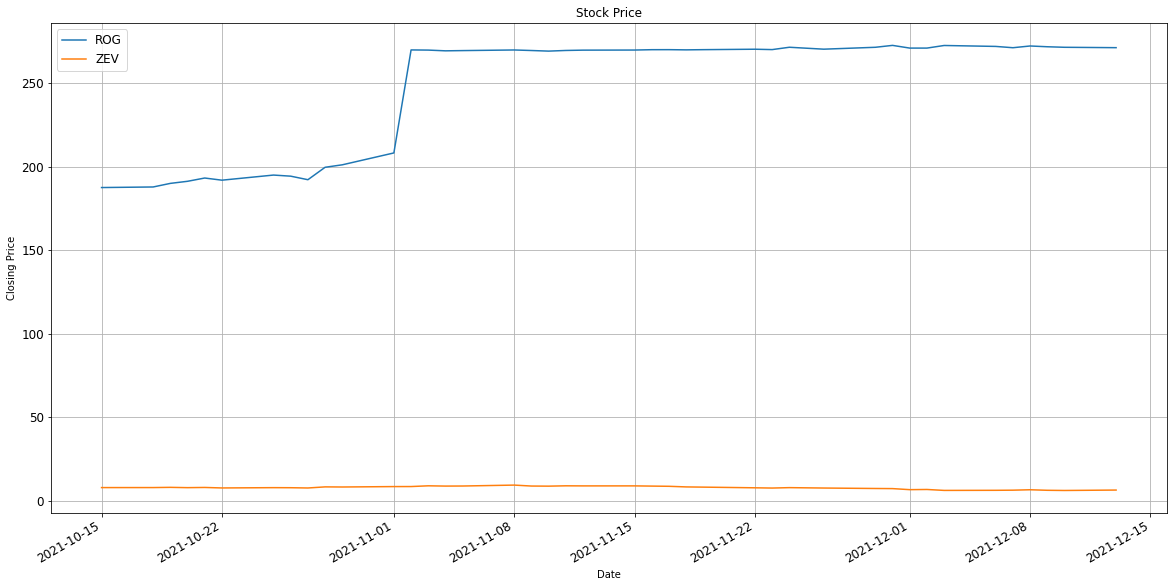

In [14]:
df = stock_df['Close']
ax = df.plot(title='Stock Price', fontsize=12, figsize=(20, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price")

plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

**Stock Volume Comparison**

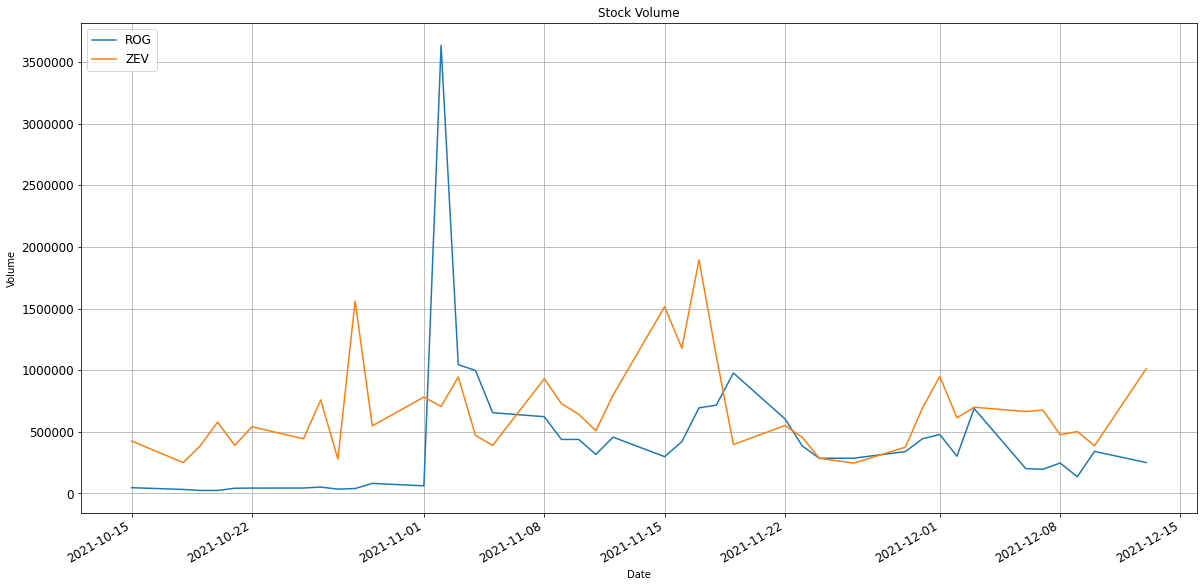

In [15]:
df = stock_df['Volume']
axis = df.plot(title='Stock Volume', fontsize=12, figsize=(20, 10))
axis.set_xlabel("Date")
axis.set_ylabel("Volume")

# to remove scientific notation from matplotlib
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

#Stock Prediction

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

**Compare Stocks for Closing value**

In [17]:
def findValuableStock():
  mean1 = stock_df['Close'][selected_stock[0]].mean()
  mean2 = stock_df['Close'][selected_stock[1]].mean()
  if mean1 > mean2:
    return selected_stock[0]
  else:
    return selected_stock[1]

predictForStock = findValuableStock()
print('Out of the two stocks', predictForStock, 'is more valuable')
print('::::::Prediction for', predictForStock, '::::::')

Out of the two stocks ROG is more valuable
::::::Prediction for ROG ::::::


**Get Stock data for 5-year period**

In [18]:
yahoo_financials = YahooFinancials(predictForStock)
data = yahoo_financials.get_historical_price_data(start_date=strFiveYearDate, 
                                                  end_date=strEndDate, 
                                                  time_interval='daily')
stockPredict_df = pd.DataFrame(data[predictForStock]['prices'])
stockPredict_df = stockPredict_df.drop('date', axis=1).set_index('formatted_date')

**Creating a new Dataframe and Training data**

In [19]:
# 1. Filter out the closing market price data
close_data = stockPredict_df.filter(['close'])

# 2. Convert the data into array for easy evaluation
dataset = close_data.values
 
# 3. Scale/Normalize the data to make all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
# 4. Creating training data size : 70% of the data
training_data_len = math.ceil(len(dataset) *.7)
train_data = scaled_data[0:training_data_len  , : ]

# 5. Separating the data into x and y data
x_train_data=[]
y_train_data =[]
for i in range(60,len(train_data)):
    x_train_data=list(x_train_data)
    y_train_data=list(y_train_data)
    x_train_data.append(train_data[i-60:i,0])
    y_train_data.append(train_data[i,0])
 
    # 6. Converting the training x and y values to numpy arrays
    x_train_data1, y_train_data1 = np.array(x_train_data), np.array(y_train_data)
 
    # 7. Reshaping training x and y data to make the calculations easier
    x_train_data2 = np.reshape(x_train_data1, (x_train_data1.shape[0],x_train_data1.shape[1],1))

**Building LSTM Mode**

In [20]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data2.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

**Compiling the Model**

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train_data2, y_train_data1, batch_size=1, epochs=1)

821/821 [==============================] - 27s 29ms/step - loss: 0.0024


**Testing the model on testing data**

In [22]:
# Creating a dataset for testing
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test = dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
 
# 2.  Convert the values into arrays for easier computation
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
 
# 3. Making predictions on the testing data
predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)


**Error Calculation**

In [23]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

176.6920867389119


**Make Predictions**

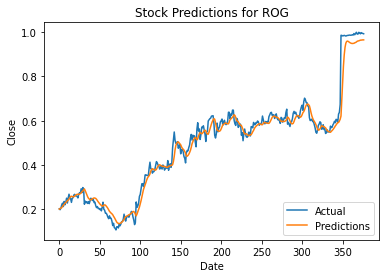

In [24]:
valid = scaled_data[training_data_len:]

predictDF = pd.DataFrame(valid, columns=['close'])
predictDF['Predictions'] = predictions

title = 'Stock Predictions for ' + predictForStock
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(predictDF['close'])
plt.plot(predictDF[['Predictions']])
 
plt.legend(['Actual', 'Predictions'], loc='lower right')
 
plt.show()